# Analysis of Diabetes Log Data

<i>By Diego Ramallo</i>

<img src="https://dl.dropboxusercontent.com/u/59776078/glucose_time_grid_header.png" alt="Drawing" style="width: 1000px;"/>

## Purpose

Update: [This version](http://nbviewer.jupyter.org/github/ramalldf/data_science/blob/master/diabetes_analysis.ipynb#Data reformatting for ensemble visualization) of the notebook has more interactivity (Bokeh plot). 

I found this interesting [diabetes log dataset](https://archive.ics.uci.edu/ml/datasets/Diabetes) on the UCI ML repository that had time series data for ~70 patients. The data for each patient was on separate .txt files, so part of the challenge involved consolidating the data to make it easy for anyone to fetch information. 

There are a lot of directions to go with this data so in order to gauge how I can leverage the data from all users, I'll begin by exploring the data for only one patient.

[Formatting Data](#Formatting Data)

[Visualizing data](#Visualizing Data)

[Data Consolidation](#Data Consolidation)

[Data reformatting for ensemble visualization](#Data reformatting for ensemble visualization)

[Constructing Glucose Time Grid](#Constructing Glucose Time Grid)

[Forecasting with STL](#Forecasting with STL)

## Formatting Data

<a id='Formatting Data'></a>

Let's look at the first subject's data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib nbagg

In [2]:
data01= pd.read_csv('Diabetes-Data/data-01', sep= '\t', header = None)
data01.columns= ['date','time','code','bg_value']
data01.head()

,date,time,code,bg_value
0,04-21-1991,9:09,58,100
1,04-21-1991,9:09,33,9
2,04-21-1991,9:09,34,13
3,04-21-1991,17:08,62,119
4,04-21-1991,17:08,33,7


Interesting. From looking at one of the files on a txt editor, I assumed that I was looking at was just blood glucose values at different times, with different events occurring. However, after reading this closer, it seems less clear that this is the case. Although there are a lot of reasonable values in the 'Value' field that I'm calling 'bg_value' here (eg. between 80-250), there are also a lot of 0-10 values which are not realistic. The documentation for the data isn't too useful. It just says that there is a code for the activity (which could've occurred at same datetime). 

I think that the 'Value' column isn't just blood-glucose, it's more realistic that it represents the value of the [code activity](https://archive.ics.uci.edu/ml/datasets/Diabetes) for that record. If that's the case, then I can just find the codes that I know are glucose measurements in order to get timelapse bg measurements :)

In [3]:
#Here's the key of codes:

codes= {
    33 : 'Regular insulin dose', 34 : 'NPH insulin dose', 
    35 : 'UltraLente insulin dose' ,48 : 'Unspecified blood glucose measurement', 
    57 : 'Unspecified blood glucose measurement', 58: 'Pre-breakfast blood glucose measurement', 
    59 : 'Post-breakfast blood glucose measurement', 60 : 'Pre-lunch blood glucose measurement', 
    61 : 'Post-lunch blood glucose measurement', 62 : 'Pre-supper blood glucose measurement', 
    63 : 'Post-supper blood glucose measurement', 64 : 'Pre-snack blood glucose measurement', 
    65 : 'Hypoglycemic symptoms', 66 : 'Typical meal ingestion', 
    67 : 'More-than-usual meal ingestion', 68 : 'Less-than-usual meal ingestion', 
    69 : 'Typical exercise activity', 70 : 'More-than-usual exercise activity', 
    71 : 'Less-than-usual exercise activity', 72 : 'Unspecified special event'
        }

glucose_codes= [48, 57, 58, 59, 60, 61, 62, 63, 64]
glucose_titles = [codes[48], codes[57], codes[58], codes[59], codes[60],
               codes[61], codes[62], codes[63], codes[64]]

Now I'll join the 'date' and 'time' columns into a single column, and drop unnecessary columns.

In [4]:
data01['datetime']= pd.to_datetime(data01['date']+' '+data01['time'])
data01= data01.drop(['date','time'], axis= 1)
data01.head()

,code,bg_value,datetime
0,58,100,1991-04-21 09:09:00
1,33,9,1991-04-21 09:09:00
2,34,13,1991-04-21 09:09:00
3,62,119,1991-04-21 17:08:00
4,33,7,1991-04-21 17:08:00


In [5]:
#Now let's filter the data so we only see glucose measurement data
glucoseOnly= data01[data01['code'].isin(glucose_codes)]

print 'These are the unique types of glucose measurements that are in our dataset: {}'.format(glucoseOnly['code'].unique())

glucoseOnly.head(5)

These are the unique types of glucose measurements that are in our dataset: [58 62 48 60]


,code,bg_value,datetime
0,58,100,1991-04-21 09:09:00
3,62,119,1991-04-21 17:08:00
5,48,123,1991-04-21 22:51:00
6,58,216,1991-04-22 07:35:00
10,62,211,1991-04-22 16:56:00


Excellent, now we know we only have codes 58, 62, 48, and 60 in our glucoseOnly table representing 'Pre-breakfast blood glucose measurement', 'Pre-supper blood glucose measurement', 'Unspecified blood glucose measurement', and 'Pre-lunch blood glucose measurement'.

Although there are other interesting codes, we can explore those later and at least visualize the data in the meantime.

## Visualizing Data

<a id='Visualizing Data'></a>

In [6]:
#One thing I'd like to do is to visualize the rolling mean (moving average) of my data
#let's calculate that (from later analysis I know 7 days centered is ideal)

bgMovingMean3= pd.rolling_mean(glucoseOnly['bg_value'],7, center=True)
print len(bgMovingMean3), len(glucoseOnly)

369 369


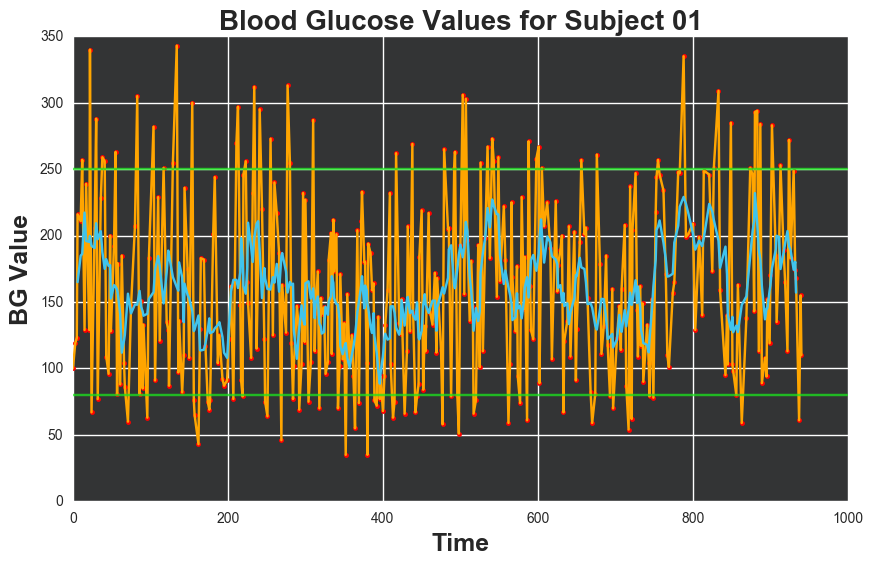

In [55]:
#Now let's plot the the time series with rolling averages
figure, ax = plt.subplots(1,1, figsize=(10,6))
plt.plot(glucoseOnly['bg_value'], '.r')
plt.plot(glucoseOnly['bg_value'], color= 'orange')
plt.plot(pd.rolling_mean(glucoseOnly['bg_value'],7, center=True), color= '#40c4ed')

#Let's also plot the thresholds for typical thresholds (below healthy range= 80, and above range = 250)
plt.plot([250]*1000, marker= '_', color= '#1be51e', alpha= 0.75)
plt.plot([80]*1000, marker= '_', color= '#1be51e', alpha= 0.75)

plt.xlabel('Time', fontsize= 18, fontweight= 'bold')
plt.ylabel('BG Value', fontsize= 18, fontweight= 'bold')
plt.title('Blood Glucose Values for Subject 01', fontsize= 20, fontweight= 'bold')
ax.set_axis_bgcolor('#333435')


For my next figure, I think it'd be neat to have an interactive plot of the raw data where I can hover over points and identify what the code was for that measurement! :)

In [9]:
%matplotlib inline

In [56]:
#Extra interactive Bokeh Figure

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models import NumeralTickFormatter
from bokeh.models import DatetimeTickFormatter


output_notebook()

#We'll now make the source for the info on our hover

source0= ColumnDataSource(data= dict(
        x= glucoseOnly['datetime'], y=  glucoseOnly['bg_value'],
        title= glucoseOnly['code'].apply(lambda x: codes[x])))


hover= HoverTool(tooltips= [("Activity", " @title")])

#Initialize figure and define attributes
p = figure(plot_width=900, plot_height=500, tools=[hover, 'wheel_zoom', 'pan', 'reset'], 
           title= "Blood Glucose Levels Over Time for Patient 01", title_text_font_size='18pt')

p.line('x', 'y', line_color= '#f2a02e', line_width= 2, source=source0)

#Finally, plot a 'skeleton' scatter plot that draws centroid for all points
#without using a data source
p.circle(glucoseOnly['datetime'], glucoseOnly['bg_value'], fill_color= 'red', line_color= 'red', source=source0)

#Now let's add the reference lines
p.line(glucoseOnly['datetime'], [250]*len(glucoseOnly['bg_value']), line_dash= 'dashed', line_color= '#1be51e')
p.line(glucoseOnly['datetime'], [80]*len(glucoseOnly['bg_value']), line_dash= 'dashed', line_color= '#1be51e')

#And finally the moving average
p.line(glucoseOnly['datetime'], bgMovingMean3, line_width= 2, line_color= '#40c4ed')


p.xaxis[0].formatter = NumeralTickFormatter(format="0")
p.yaxis[0].formatter = NumeralTickFormatter(format="0")

p.xaxis.formatter=DatetimeTickFormatter(formats=dict(
        hours=["%d %B %Y"],
        days=["%d %B %Y"],
        months=["%d %B %Y"],
        years=["%d %B %Y"],
    ))

p.xaxis.major_label_orientation = np.pi/4

p.xaxis.axis_label = "Date"
p.yaxis.axis_label = "Blood Glucose Level"
p.xaxis.axis_label_text_font_size = "12pt"
p.yaxis.axis_label_text_font_size = "12pt"

p.background_fill = "#333435"

p.title_text_font_style = "bold"

show(p)

Loading BokehJS ...

Great! Now I can hover over a timepoint and look more closely at the events associated with that BG value.

## Data Consolidation

<a id='Data Consolidation'></a>

Now that I more or less understand a single user's data, I think it could be useful to put the data for ALL users into the same table. We could use the file suffix as the user_id as an extra column and potentially one hot encode the codes to turn them into features we could use. Let's first look at the files that are at our disposal. I know our files are in a subfolder called 'Diabetes-Data'.

In [11]:
import os 

subDir= os.listdir(os.getcwd() +'/Diabetes-Data')
print subDir

['data-01', 'data-02', 'data-03', 'data-04', 'data-05', 'data-06', 'data-07', 'data-08', 'data-09', 'data-10', 'data-11', 'data-12', 'data-13', 'data-14', 'data-15', 'data-16', 'data-17', 'data-18', 'data-19', 'data-20', 'data-21', 'data-22', 'data-23', 'data-24', 'data-25', 'data-26', 'data-27', 'data-28', 'data-29', 'data-30', 'data-31', 'data-32', 'data-33', 'data-34', 'data-35', 'data-36', 'data-37', 'data-38', 'data-39', 'data-40', 'data-41', 'data-42', 'data-43', 'data-44', 'data-45', 'data-46', 'data-47', 'data-48', 'data-49', 'data-50', 'data-51', 'data-52', 'data-53', 'data-54', 'data-55', 'data-56', 'data-57', 'data-58', 'data-59', 'data-60', 'data-61', 'data-62', 'data-63', 'data-64', 'data-65', 'data-66', 'data-67', 'data-68', 'data-69', 'data-70', 'Data-Codes', 'Domain-Description', 'README-DIABETES']


Ok so we know that there are 70 files. Our goal is to append the content of each table to a new dataframe that will contain the total data. This is how our workflow will work for each one:

1) Open new dataframe

2) Assign a userid that matches the item number in our iteration for all rows that belong to this file.

3) Perform a union to append the content of new dataframe to total dataframe.

Since our items of interest are the first 70 items in our list, we'll just start the loop there instead of doing regex to match requisites for our file title :)

In [12]:
#Initialize totalData dataframe

totalData= pd.DataFrame(columns= ['date','time','code','bg_value','uid'])

In [13]:
uidList= []
uidList.extend([range(19),range(20,66),range(67,70)])
uidList= [j for i in uidList for j in i]
print uidList

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69]


In [14]:
#Iterate through our directory list and concatenate rows from
#different users to totalData dataframe

for i in uidList:
    
    tempData= pd.read_csv('Diabetes-Data/' + subDir[i], sep= '\t', header = None)
    tempData.columns= ['date','time','code','bg_value']
    
    tempData['datetime']= pd.to_datetime(tempData['date']+' '+tempData['time'])
    tempData= tempData.drop(['date','time'], axis= 1)
    tempUid= [i+1]*len(tempData)
    tempData['uid']= tempUid
    totalData= pd.concat([totalData,tempData])

I got errors reading files 19 and 66. Basically they said that the number of days didn't match that particular month. So for now, I just skipped them. I'll also drop the 'date' and 'time' columns since I already added the 'datetime' column. (0,19), (20,66), (67,70)

In [15]:
totalData= totalData.drop(['date','time'], axis=1)
totalData.head()

,bg_value,code,datetime,uid
0,100,58.0,1991-04-21 09:09:00,1.0
1,9,33.0,1991-04-21 09:09:00,1.0
2,13,34.0,1991-04-21 09:09:00,1.0
3,119,62.0,1991-04-21 17:08:00,1.0
4,7,33.0,1991-04-21 17:08:00,1.0


In [16]:
#Now let's calculate the dimensions of our dataset and list the 
#unique uids in our table
print totalData.shape
len(totalData['uid'].unique())

(27360, 4)


68

In [17]:
#Finally, let's write this table to a csv 
#so that we can just load it later and make it available to others

totalData.to_csv('diabetes_total_data',header=True)

## Data reformatting for ensemble visualization

<a id='Data reformatting for ensemble visualization'></a>

I haven't looked at every file, and ideally it would be easier to compare subjects if measurements were recorded on the same days, but I suspect that's not the case. In this section I'll explore how many dates we'll work with to determine what our figure will look like. 

In [18]:
#Let's see how many original time points we'd be working with
len(totalData['datetime'].unique())

13903

Geez, that's a lot of points. Let's check how many unique codes there are. We could potentially one hot encode these to use as features for machine learning in the future. I'll also try to filter our data to only include our glucose data for now.

In [19]:
bgData= totalData[totalData['code'].isin(glucose_codes)]
bgData.head()

,bg_value,code,datetime,uid
0,100,58.0,1991-04-21 09:09:00,1.0
3,119,62.0,1991-04-21 17:08:00,1.0
5,123,48.0,1991-04-21 22:51:00,1.0
6,216,58.0,1991-04-22 07:35:00,1.0
10,211,62.0,1991-04-22 16:56:00,1.0


In [20]:
bgData['code'].unique()

array([ 58.,  62.,  48.,  60.,  64.,  61.,  63.,  57.,  59.])

So I think that keeping the time column instead of date column will be more useful for predictions. Having the date column without the time component can make it easier to visualize the data though. Let's try removing the time first.

In [21]:
bgDataDate= bgData.copy()
bgDataDate['datetime']= bgData['datetime'].dt.date
print bgDataDate.shape
bgDataDate.head()

(12610, 4)


,bg_value,code,datetime,uid
0,100,58.0,1991-04-21,1.0
3,119,62.0,1991-04-21,1.0
5,123,48.0,1991-04-21,1.0
6,216,58.0,1991-04-22,1.0
10,211,62.0,1991-04-22,1.0


In [22]:
len(bgDataDate['bg_value'].unique())

686

Ok so it looks like there are still a lot of dates. I'm now going to group by datetime, uid, and code in order to average each user's glucose measurements by date. 

In [23]:
dataReduced= bgDataDate.copy()
dataReduced['bg_value']= dataReduced['bg_value'].convert_objects(convert_numeric=True)

In [24]:
#Check that our datatypes are numeric so we can perform median calculation
dataReduced.dtypes

bg_value    float64
code        float64
datetime     object
uid         float64
dtype: object

In [25]:
dataReduced= dataReduced.groupby(['datetime','uid']).median()
dataReduced.head()

,,bg_value,code
datetime,uid,,
1988-03-27,68.0,158.0,60.0
1988-03-28,68.0,135.0,60.0
1988-03-31,68.0,147.0,60.0
1988-04-02,68.0,136.0,60.0
1988-04-04,68.0,111.5,60.0


OK above, I grouped the table by day and then I took the median bg_value for that date. Below, I changed that hierarchical table back into a regular pandas dataframe.

In [26]:
dataReduced= dataReduced.reset_index()
dataReduced.head(3)

,datetime,uid,bg_value,code
0,1988-03-27,68.0,158.0,60.0
1,1988-03-28,68.0,135.0,60.0
2,1988-03-31,68.0,147.0,60.0


Ok now that we have this, in theory we can construct a table that has users as rows and datetime as columns. Not every column will have a value, but we can just keep a null there, then do the imshow command to make the heatmap. The last fancy thing we could add is ranking the users by median bg value?

## Constructing Glucose Time Grid

<a id='Constructing Glucose Time Grid'></a>

In [27]:
#First let's determine the dimensions of our current dataframe
print dataReduced.shape

(3606, 4)


In [28]:
#Just checking if we can query a table 's column (bg_value here) if we specify value for uid
158.0 in dataReduced[dataReduced['uid']== 68]['bg_value'].tolist()

True

In [29]:
#Here I'm just checking that given TWO CONDITIONS (uid value and code value), 
#I can return the corresponding bg_value (this works here, but notice how it won't in our 
#inner loop below. Look at line 13 in our nested loop cell. There we'll have to use ...['bg_value'].item())
dataReduced[(dataReduced['uid']== 68) & (dataReduced['code']== 60.0)]['bg_value'][0]

158.0

Now we'll start constructing the glucose time grid. The first thing we need to do is define the x-axis. Here it will be time and each column will correspond to a unique datetime value (which will have a corresponding index to simplify its construction). 

Thus, we'll 1) sort a unique list of dates, 2) create indices for them, and 3) finally map the dates to the indices in a dictionary. 

In [30]:
dates= np.sort(np.array(bgDataDate['datetime'].unique()))
dateIndex= [i for i in range(0,len(dates))]
dateDict= dict(zip(dateIndex,dates))

To clarify: We want to visualize the glucose values for all users, but not all users had glucose activity on those dates (~1100 days). That means that most of our users will have blanks at the majority of the columns. 

Below, we'll interate through the rows (uids, i), then columns (datetimes) in our new matrix. If the user has a value on that date (column), then we'll assign the corresponding median bg value to that cell, else we'll just add a nan (nans are more useful to calculate statistics on matrix, a zero will be more useful for plotting grid, but we can replace nans right before we imshow grid).

In [31]:
#Initialize list of lists
glucTimeGrid= []

#Iterate through unique user ids (sorted already) and initialize row vector
for i in bgDataDate['uid'].unique():
    rowVector= []
    #Iterate through dates (via date indices)
    for j in range(0,len(dateIndex)):
        #If dateDict[index], which is a date, is in user's list of dates
        if dateDict[j] in dataReduced[dataReduced['uid']== i]['datetime'].tolist():
            #Append bg_value for given (uid & date) (add print j if wanna troubleshoot)
            rowVector.append(dataReduced[(dataReduced['uid']== i) & 
                                           (dataReduced['datetime']== dateDict[j])]['bg_value'].item())
        else:
            #Else append 0
            rowVector.append(np.nan)
    #Append row to list of lists (glucose matrix)        
    glucTimeGrid.append(rowVector)

In [32]:
#Let's check the dimensions of our final matrix
np.array(glucTimeGrid).shape

(68, 1118)

If you want to doublecheck the results of individual uid's or rows, you can check the value of rowVector. You can also check the values of a subset of the glucTimeGrid to see if it makes sense (should be lots of nans and then a short sequence of non-nan numbers.

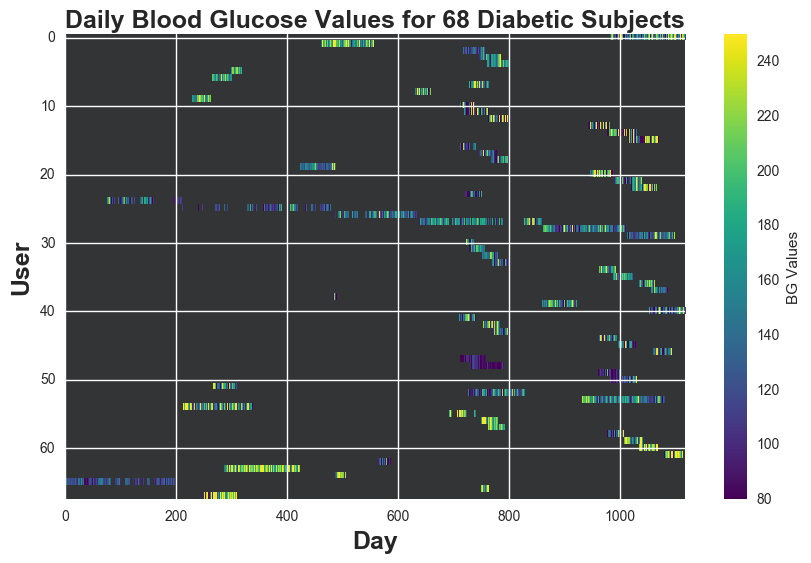

In [33]:
%matplotlib inline
figure, ax = plt.subplots(1,1, figsize=(10,6))
plt.imshow(np.array(glucTimeGrid), interpolation='nearest',cmap= 'viridis', vmax= 250, vmin= 80)
plt.colorbar(label='BG Values')
ax.set_aspect('auto')
ax.set_axis_bgcolor('#333435')
plt.xlabel('Day', fontsize= 18, fontweight= 'bold')
plt.ylabel('User', fontsize= 18, fontweight= 'bold')
plt.title('Daily Blood Glucose Values for 68 Diabetic Subjects', fontsize= 18, fontweight= 'bold')

This is great! Now we have a good way of monitoring everyone's daily glucose levels and to pick out the unhealthy ones very easily. 

The next thing we want to do is make predictions about the daily blood glucose values for each subject. There are a few ways to do this, but since we're working with daily intervals, I'll begin with the 'Seasonal and Trend decomposition using Loess' method.

## Forecasting with STL

<a id='Forecasting with STL'></a>

The idea is that as opposed to modeling the time series as a linear combo of certain features, we can model it as a product of the three components of the response/target/y data. This means breaking down y into seasonal (S), trend (T), and remainder/irregular components (I). We can calculate each and then use their sum to predict future blood glucose values: 

\begin{align}
\ y = S+T+I \\
\end{align}

To calculate the trend, we'll use the centered moving average (CMA) estimate. We'll then detrend y (subtract trend from y) and use this detrended y to calculate a seasonal component (averages for every nth day in our 7 day season) that we'll extend as a separate vector for the length of the CMA. Finally, the irregular component is just a product of y and 1/(SxT). 

### Trend Component (T)

Since the dataset that's been binned to individual days is the data in our glucTimeGrid, we have to use that to begin to calculate all the components. Loading it as a series in pandas will give us additional tools to deal with missing values. 

Let's start by finding the indices of the first and last non missing value positions in our row. We'll fill in the missing values in this subset of data and then calculate our 7 day CMA. 

In [35]:
#Turn first row to series, find indices of edge non-nans
sliceDays= pd.Series(glucTimeGrid[0])
firstValid= sliceDays.first_valid_index()
lastValid= sliceDays.last_valid_index()

print firstValid, lastValid

982 1117


Now we'll use edge indices to slice row, fillna, and apply moving average. This will be our baseline. We'll then take the n-th value averages to calculate a weekly vector average that will be extended for the length of the baseline to give us a season component. Finally, We'll divide y by the baseline to get S x I

In [60]:
#Define and fill in missing values from original trace
y_bg= pd.Series(glucTimeGrid[0][firstValid:lastValid+1])
y_bg= y_bg.fillna(np.median(y_bg))

#Define trend as the rolling mean for a 7 day 'season'
trend= pd.rolling_mean(y_bg,7, center=True)
detrendY= y_bg-trend
print 'Total, trend, detrended'
zip(y_bg.head(10), trend.head(10), detrendY.head(10))

Total, trend, detrended


[(119.0, nan, nan),
 (213.5, nan, nan),
 (193.0, nan, nan),
 (239.0, 197.21428571428572, 41.785714285714278),
 (206.0, 195.78571428571428, 10.214285714285722),
 (152.5, 188.14285714285714, -35.642857142857139),
 (257.5, 180.78571428571428, 76.714285714285722),
 (109.0, 157.07142857142858, -48.071428571428584),
 (160.0, 152.92857142857142, 7.0714285714285836),
 (141.5, 148.0, -6.5)]

The remaining nans are a result of using a centered moving average when the window is large enough. This should be ok because our seasonal measurement calculations will ignore these in the next step. 

## Season and Irregular Components

Seasonality is calculated by taking the average of every nth element. Since we have 7 days, we'll calculate 7 means using the <i>detrended</i> y values.

We'll first slice trend to a multiple of 7, then rehape our matrix to have 7 columns. We'll end by taking the nan mean of this matrix along columns, leaving us with a vector of 7 averages.

In [67]:
#Calculate quotient and remainders to build our matrix
weekQuotient= len(trend)/7
weekRem= len(trend)%7

#Now we'll 1)Turn our series to an array 2) slice it to reshape it into a 7 column matrix
#3) Take the nanmean along columns to give us a weekly 7 element vector
weeklyMean= np.array(detrendY)[:-(weekRem)].reshape(-1,7)

#Print rows and columns (should have 7 columns)
print weeklyMean.shape

(19, 7)


In [68]:
#Dimensions look correct, now average down columns
weeklyMean= np.nanmean(weeklyMean, axis=0)
weeklyMean

array([ 14.86111111, -23.38095238, -22.59126984,   6.51879699,
        -6.4887218 ,  23.55639098,   8.02255639])

I can now extend this 7 vector for the length of our original baseline. Finally, the irregular component can be calculated to be the difference between our original trace (y_bg) and the sum of our season and our trend.

In [69]:
#Extend season trend for length of time series and calculate irregular term
season= list(weeklyMean)*weekQuotient
season.extend(weeklyMean[:weekRem])
print len(trend), len(season)

#Calculate irregular term (remainder term)
irregular= y_bg-season-trend

#Line up total and components
print 'Time Series, Trend, Season, Irregular'
zip(y_bg, trend, season,irregular)[:10]

136 136
Time Series, Trend, Season, Irregular


[(119.0, nan, 14.861111111111111, nan),
 (213.5, nan, -23.380952380952383, nan),
 (193.0, nan, -22.591269841269842, nan),
 (239.0, 197.21428571428572, 6.5187969924812039, 35.266917293233064),
 (206.0, 195.78571428571428, -6.4887218045112789, 16.703007518796994),
 (152.5, 188.14285714285714, 23.556390977443609, -59.199248120300751),
 (257.5, 180.78571428571428, 8.0225563909774458, 68.691729323308266),
 (109.0, 157.07142857142858, 14.861111111111111, -62.932539682539698),
 (160.0, 152.92857142857142, -23.380952380952383, 30.452380952380963),
 (141.5, 148.0, -22.591269841269842, 16.091269841269849)]

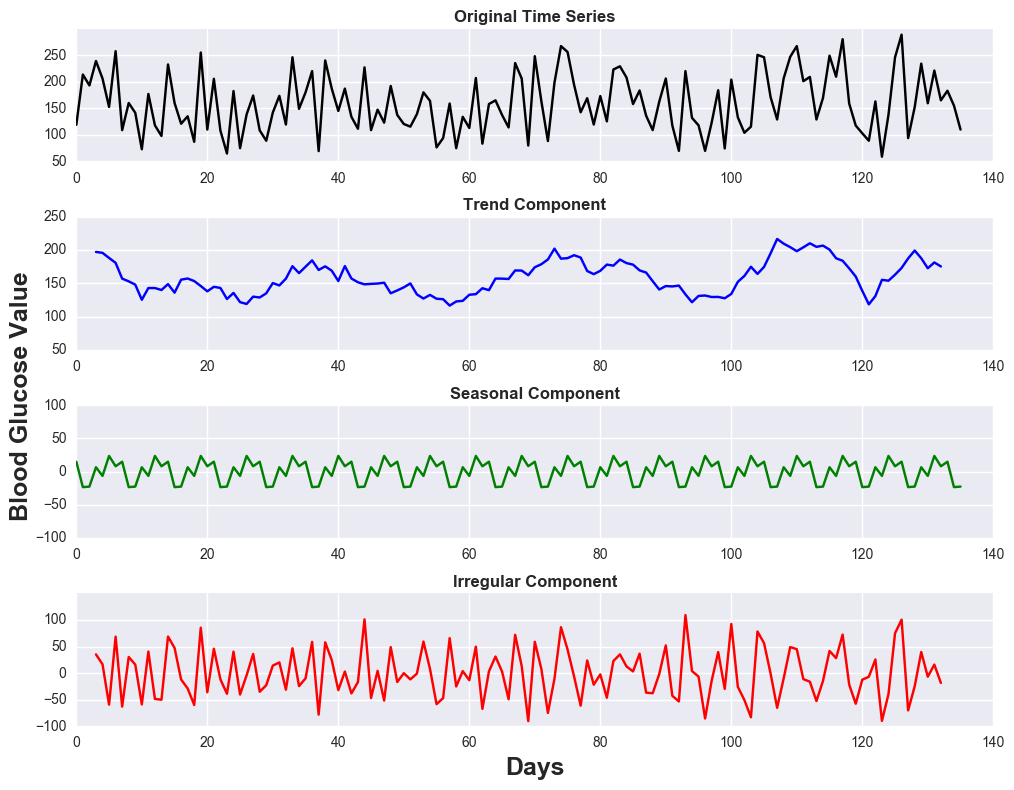

In [70]:
#Plot figures of total and components
figure, ax= plt.subplots(4,1, figsize=(10,8))

plt.subplot(4,1,1)
plt.plot(y_bg, 'black')
plt.yticks(range(50,300,50))
plt.title('Original Time Series', fontweight= 'bold')

plt.subplot(4,1,2)
plt.plot(trend, 'blue')
plt.yticks(range(50,300,50))
plt.title('Trend Component', fontweight= 'bold')

plt.subplot(4,1,3)
plt.plot(season, 'green')
plt.yticks(range(-100,125,50))
plt.title('Seasonal Component', fontweight= 'bold')

plt.subplot(4,1,4)
plt.plot(irregular, 'red')
plt.yticks(range(-100,125,50))
plt.xlabel('Days', fontsize= 18, fontweight= 'bold')
figure.text(-0.01, 0.5, 'Blood Glucose Value', va='center', rotation='vertical', fontsize= 18, fontweight= 'bold')
plt.title('Irregular Component', fontweight= 'bold')

plt.tight_layout()

Awesome! So now I've been able to split a time series into it's components. The next step will involve actual predictions and comparisons to other forecasting models.

## Other Random Analysis

I can also incorporate info about each day's activities in my predictions. I'm not completely sure about how to integrate that info into the time series analysis above (maybe a combination of linear regression with the STL analysis?), but this is something that I'll work on once I try a few simple models out. 

I can start with the bgData object which includes all the users data in one table and I can try to one-hot encode the code values into features. 

In [108]:
bgData.head()

,bg_value,code,datetime,uid
0,100,58.0,1991-04-21 09:09:00,1.0
3,119,62.0,1991-04-21 17:08:00,1.0
5,123,48.0,1991-04-21 22:51:00,1.0
6,216,58.0,1991-04-22 07:35:00,1.0
10,211,62.0,1991-04-22 16:56:00,1.0


In [110]:
bgDataTime= bgData[['bg_value','code','datetime']]
bgDataTime['datetime']= bgData['datetime'].dt.time
bgDataTime.head()

,bg_value,code,datetime
0,100,58.0,09:09:00
3,119,62.0,17:08:00
5,123,48.0,22:51:00
6,216,58.0,07:35:00
10,211,62.0,16:56:00


Now we'll one-hot encode the code values to make them into separate features.

In [111]:
for elem in bgDataTime['code'].unique():
        bgDataTime[str(elem)] = bgDataTime['code'] == elem
bgDataTime.head(3)

,bg_value,code,datetime,58.0,62.0,48.0,60.0,64.0,61.0,63.0,57.0,59.0
0,100,58.0,09:09:00,True,False,False,False,False,False,False,False,False
3,119,62.0,17:08:00,False,True,False,False,False,False,False,False,False
5,123,48.0,22:51:00,False,False,True,False,False,False,False,False,False


In [116]:
#Finally, drop the 'code' column
bgDataTime= bgDataTime.drop('code', axis=1)
bgDataTime.head(3)

,bg_value,datetime,58.0,62.0,48.0,60.0,64.0,61.0,63.0,57.0,59.0
0,100,09:09:00,True,False,False,False,False,False,False,False,False
3,119,17:08:00,False,True,False,False,False,False,False,False,False
5,123,22:51:00,False,False,True,False,False,False,False,False,False


Extra Plot (decomposition and recomposition)